In [30]:
#import
import sys
from PIL import Image
from ast import literal_eval
import random
import time
import math
from matplotlib.pyplot import imshow
import numpy as np

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
def input_imag(imageName):
  #Open and read img
  im = Image.open(imageName)
  pix = im.load()
  xVal,yVal = im.size
  pointsArray = []

  #Map pixel values to array
  for y in range(yVal):
      pointsArray.append([])
      for x in range(xVal):
          pointsArray[y].append(list(pix[x,y]))
  
  %matplotlib inline
  imshow(np.asarray(im))
  print(im.size)
  
  return pointsArray


(200, 112)


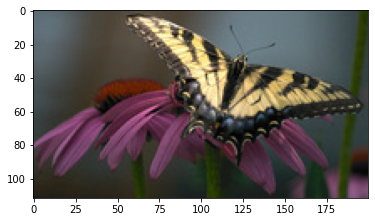

In [35]:
#imageName_km = '/content/drive/MyDrive/Colab Notebooks/1_butterfly.jpg'

imageName = '/content/drive/MyDrive/Colab Notebooks/1_butterflySmaller.jpg'
pointsArray = input_imag(imageName)

In [19]:
def KMEANS(vectors,kVal):
  #choose k initial random unequal points
  centerPoints = []
  while len(centerPoints) != kVal:
      candidate = random.choice(random.choice(vectors))
      if candidate not in centerPoints:
          centerPoints.append(candidate)

  #clustering
  testPrev = []
  iterationCounter = 0
  while True:
      clusteringTable = []
      for y in range(len(vectors)):
          clusteringTable.append([])
          for x in range(len(vectors[0])):
              temp = []
              temp.append(vectors[y][x])
              for k in range(kVal):
                  #distance from center point
                  distance = 0
                  for l in range(len(centerPoints[0])):
                      distance = distance + abs(centerPoints[k][l]-vectors[y][x][l])
                  temp.append(distance)
              #assign cluster centroid with min distance
              temp.append(temp[1:].index(min(temp[1:])))
              clusteringTable[y].append(temp)
      
      #check if cluster values changed, exit otherwise
      test = []
      for k in range(kVal):
          test.append(0)
          for itemY in clusteringTable:
              for itemX in itemY:
                  if itemX[-1] == k:
                      test[k] = test[k] + 1
      if testPrev == test:
          break
      testPrev = test
      
      #update centroids
      for k in range(kVal):
          n = 0
          vectorTemps = [0]*len(clusteringTable[0][0][0])
          for itemY in clusteringTable:
              for itemX in itemY:
                  if itemX[-1] == k:
                      for valCounter in range(len(itemX[0])):
                          vectorTemps[valCounter] = vectorTemps[valCounter] + itemX[0][valCounter]
                      n = n + 1
          #check for 0 division
          for valCounter in range(len(vectorTemps)):
              if vectorTemps[valCounter] != 0:
                  vectorTemps[valCounter] = vectorTemps[valCounter]/n
          centerPoints[k] = vectorTemps
      iterationCounter = iterationCounter + 1

  #Build clustered array
  clusteredVectors = []
  for y in range(len(clusteringTable)):
      clusteredVectors.append([])
      for x in range(len(clusteringTable[0])):
          clusteredVectors[y].append(centerPoints[clusteringTable[y][x][-1]])
  
  return clusteredVectors



DBSCAN

In [20]:
def EuclideanDistance(P,Q):
    intermediateValues = []
    for i in range(len(P[2])):
        intermediateValues.append(math.pow(Q[2][i]-P[2][i],2))
    return math.sqrt(sum(intermediateValues))

In [21]:
def MaximumDistance(P,Q):
    intermediateValues = []
    for i in range(len(P[2])):
        intermediateValues.append(abs(Q[2][i]-P[2][i]))
    return max(intermediateValues)

In [22]:
def FindNeighbours(Point, Points, distanceFunction, eps):
    tempNeighbours = []
    for y in range(len(Points)):
        for x in range(len(Points[0])):
            if distanceFunction == "e":
                if EuclideanDistance(Point, Points[y][x]) <= eps:
                    tempNeighbours.append(Points[y][x])
            if distanceFunction == "m":
                if MaximumDistance(Point, Points[y][x]) <= eps:
                    tempNeighbours.append(Points[y][x])
    return tempNeighbours

In [23]:
def DBSCAN(vectors,eps,minPts):
  distFunc = 'e'
  #prepare array
  pointsArray = []
  for y in range(len(vectors)):
      pointsArray.append([])
      for x in range(len(vectors[0])):
          pointsArray[y].append([y,x,vectors[y][x],"Undefined"])
  #DBSCAN
  clusterCounter = 0
  progress = 0
  for y in range(len(vectors)):
      for x in range(len(vectors[0])):
          if pointsArray[y][x][-1] != "Undefined":
              continue

          Neighbours = FindNeighbours(pointsArray[y][x], pointsArray, distFunc, eps)
          if len(Neighbours) < minPts:
              pointsArray[y][x][-1] = "Noise"
              continue
          
          clusterCounter = clusterCounter + 1
          pointsArray[y][x][-1] = str(clusterCounter)
          if pointsArray[y][x] in Neighbours:
              Neighbours.remove(pointsArray[y][x])
          
          for innerPoint in Neighbours:
              if innerPoint[-1] == "Noise":
                  pointsArray[innerPoint[0]][innerPoint[1]][-1] = str(clusterCounter)
              if innerPoint[-1] != "Undefined":
                  continue
              pointsArray[innerPoint[0]][innerPoint[1]][-1] = str(clusterCounter)
              NeighboursInner = FindNeighbours(innerPoint, pointsArray, distFunc, eps)
              if len(NeighboursInner) >= minPts:
                  Neighbours.append(NeighboursInner)
  #Get distinct clusters
  clusterNumbers = []
  for y in range(len(vectors)):
      for x in range(len(vectors[0])):
          if pointsArray[y][x][-1] not in clusterNumbers:
              clusterNumbers.append(pointsArray[y][x][-1])

  #Map cluster's averages
  averagesForClusters = []
  for item in clusterNumbers:
      n = 0
      vectorTemps = [0]*len(pointsArray[0][0][2])
      for y in range(len(vectors)):
          for x in range(len(vectors[0])):
              if pointsArray[y][x][-1] == item:
                  for i in range(len(pointsArray[y][x][2])):
                      vectorTemps[i] = vectorTemps[i] + pointsArray[y][x][2][i]
                  n = n + 1
      #Check 0 division
      for i in range(len(vectorTemps)):
          if vectorTemps[i] != 0:
              vectorTemps[i] = vectorTemps[i]/n
      averagesForClusters.append(vectorTemps)

  #Build clustered array and change cluster averages with initial values
  clusteredVectors = []
  for y in range(len(pointsArray)):
      clusteredVectors.append([])
      for x in range(len(pointsArray[0])):
          clusteredVectors[y].append(averagesForClusters[clusterNumbers.index(pointsArray[y][x][-1])])
  
  return clusteredVectors

In [24]:
def imag_save(clusteredVectors,outputName):
  #vectors = literal_eval(sys.stdin.read())
  #outputName = "2_butterfly2means.jpg"
  modelLen = len(clusteredVectors[0][0])

  #Check supported model and initialize image
  if modelLen == 3:
      image = Image.new('RGB', (len(clusteredVectors[0]),len(clusteredVectors)))
  elif modelLen == 4:
      image = Image.new('RGBA', (len(clusteredVectors[0]),len(clusteredVectors)))
  else:
      print("Unsupported model")
      sys.exit(1)

  #Map array values to image and save
  pix = image.load()
  for y in range(len(clusteredVectors)):
      for x in range(len(clusteredVectors[0])):
          r = int(round(clusteredVectors[y][x][0]))
          g = int(round(clusteredVectors[y][x][1]))
          b = int(round(clusteredVectors[y][x][2]))
          if modelLen == 3:
              pix[x,y] = (r,g,b)
          elif modelLen == 4:
              a = int(round(clusteredVectors[y][x][3]))
              pix[x,y] = (r,g,b,a)

  image.save(outputName)


In [25]:
clusteredVectors_km = KMEANS(pointsArray,3)
imag_save(clusteredVectors_km,'kmeans_op.jpg')

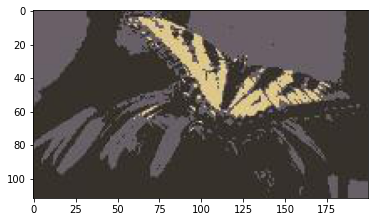

In [26]:
imageName_kmop = '/content/kmeans_op.jpg'
KM_OP = input_imag(imageName_kmop)

In [27]:
clusteredVectors_db = DBSCAN(vectors,100,100)
imag_save(clusteredVectors_db,'dbscan_op.jpg')

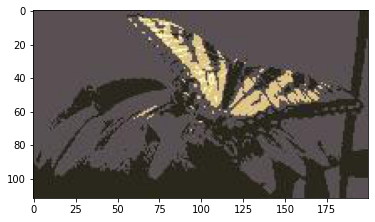

In [28]:
imageName_dbop = '/content/dbscan_op.jpg'
db_OP = input_imag(imageName_dbop)